In [1]:
import tensorflow as tf
from tensorflow.python.compiler.tensorrt import trt_convert as trt
import tensorflow.keras as tfk
import random
import os
import pathlib
from tensorflow.keras.models import load_model
from tensorflow.compat.v1.graph_util import convert_variables_to_constants
from tensorflow.python.platform import gfile
from tensorflow.python.tools import freeze_graph

In [2]:
base_path = os.getcwd()
keras_model_pfad = "keras_model_sign_rop_vgg_ohne_gen_1.h5"
tf_model_pfad = os.path.join(base_path,'../Models/Tensor-Model/Tensor_')
fr_graph_tf_model = tf_model_pfad + "frozen_model_tf.pb"
fr_graph_trt_model =os.path.join(base_path,'../Models/RT-Model/frozen_model_trt.pb')

### Keras zu Tensorflow-Model

In [3]:
 """
diese Funktion wird ein Keras-Model in ein Tensor-Model
Umwandeln
"""
""" da die Batchnormalisation-Parameter im Keras
als trainable parameter gespeichert sind, mussen wird diese als
non_trainable zurücksetzen
"""
tf.keras.backend.set_learning_phase(0)

print("Keras-Model wird hochgeladen!")
try:
    model = load_model(keras_model_pfad)
except FileNotFoundError:
    print("Kein .h5-Datei wurde gefunden!")
    exit()
# get input und output des models for tensorflow improvement
print("Input node for the this Model is:")
input_node = model.inputs[0].name
print(input_node)
output_node = model.outputs[0].name
print("output node for the this Model is:")
print(output_node)
print("Umwandlung vom Keras zu Tensor-Model..")

saver = tf.train.Saver()
# keras session wird als tf- Session gelesen!
sess = tf.keras.backend.get_session()
save_path = saver.save(sess, tf_model_pfad)
tf.keras.backend.clear_session()
print("Umgewandelt und gespeichert!")

Keras-Model wird hochgeladen!
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Input node for the this Model is:
conv2d_12_input:0
output node for the this Model is:
dense_5/Softmax:0
Umwandlung vom Keras zu Tensor-Model..
Umgewandelt und gespeichert!


### Umwandlung vom Tensorflow - Model zu tensorRT-Frozen-Model

Es wird im folgenden Skripten erst Tensorflow frozen-Model geschafft und wird danach das optimierte tensortRT-Model durch TensorRT modul von Tensorflow.  

In [4]:
"""
 das aus Keras-Model Generierte Tensort-Model(oder ein normales
 Tensor-Model) wird hochgeladen
 und in frozen Graph umgewandelt
 input : tensor-Model
 ouput : frozen graph .pd
"""
with tf.Session() as sess:
    # import of meta graph fo tensorflow model
    path_meta_file = tf_model_pfad + ".meta"
    saver = tf.train.import_meta_graph(path_meta_file)
    # print(graph)
    # exit()
    # restore the weights to the meta graph
    saver.restore(sess, tf_model_pfad)

    # specify the tensor output of the model
    """output_models = [n.name for
                     n in tf.get_default_graph().as_graph_def().node
                    if "dense_5/Softmax" in n.name]
    print(output_models)"""
    output_model = output_node.split(':')[0]
    # convert to frozen model
    print("Frozen model ergestellt!")
    frozen_graph = convert_variables_to_constants(sess,
                                                  tf.get_default_graph().as_graph_def(),
                                                  output_node_names=[output_model])

    # save the frozen graph
    print("speichert!")
    with gfile.FastGFile(fr_graph_tf_model, "wb") as f:
        f.write(frozen_graph.SerializeToString())
    print("Frozen model wurde gespeichert!")
    

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /home/kamgo/Donnees/Master_projekt/TensorRT/Verkehrszeichenerkennung/jupyter/../Models/Tensor-Model/Tensor_
Frozen model ergestellt!
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 12 variables.
INFO:tensorflow:Converted 12 variables to const ops.
speichert!
Instructions for updating:
Use tf.gfile.GFile.
Frozen model wurde gespeichert!


### Tensorflow-Frozen zu TensorRT-Model

In [5]:
# Erstellung von TRT-Frozen-Model
## read tensorflozen-Graph
# set the memory fraction eg. 0.2 meaning tf use 20% of gpu and
# the rest will be used bei Trt
gpu_option = tf.GPUOptions(per_process_gpu_memory_fraction=0.5)
with tf.Session(config=tf.ConfigProto(gpu_options=gpu_option)) as sess:
    try:
        with tf.gfile.GFile(fr_graph_tf_model, "rb") as f:
            graph_def = tf.GraphDef()
            graph_def.ParseFromString(f.read())
    except:
        print("Frozen graph wurde nicht gefunden!")
    
    from tensorflow.python.compiler.tensorrt import trt_convert as trt
    converter = trt.TrtGraphConverter(input_graph_def=graph_def,
                                      nodes_blacklist=[output_node],
                                      precision_mode='FP16',
                                      max_batch_size=1,
                                      max_workspace_size_bytes=1 << 32,
                                      use_calibration=False)
    trt_frozen_graph = converter.convert()
    # save the frozen graph
    print("speichert!")
    with gfile.FastGFile(fr_graph_trt_model, "wb") as f:
        f.write(trt_frozen_graph.SerializeToString())
    print("Frozen model wurde gespeichert!")


INFO:tensorflow:Linked TensorRT version: (0, 0, 0)
INFO:tensorflow:Loaded TensorRT version: (0, 0, 0)
INFO:tensorflow:Running against TensorRT version 0.0.0
speichert!
Frozen model wurde gespeichert!


##  Improve Model

gelesen wird: Verbot für Kraftfahrzeuge
gelesen wird: Zulässige Höchstgeschwindigkeit (30 km/h)
gelesen wird: vorgeschriebene Vorbeifahrt (rechts vorbei)
gelesen wird: Kurve(Rechts)


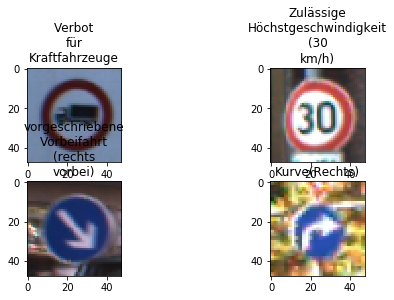

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
import time
import numpy as np

IMG_SIZE = 48
pfad_beschreibung = os.path.join(base_path,"../Daten/utils/Text_Beschreibung.csv")
classe_label = pd.read_csv(pfad_beschreibung)
classe_label = classe_label.set_index('ClassId').T.to_dict()

# Bilder werden einglesen im RGB-Format
img0 = cv2.imread("00000.ppm", cv2.IMREAD_UNCHANGED)
print("gelesen wird:",classe_label[16]['SignName'])
img1 = cv2.imread("00001.ppm", cv2.IMREAD_UNCHANGED)
print("gelesen wird:",classe_label[1]['SignName'])
img2 = cv2.imread("00002.ppm", cv2.IMREAD_UNCHANGED)
print("gelesen wird:",classe_label[38]['SignName'])
img3 = cv2.imread("00003.ppm", cv2.IMREAD_UNCHANGED)
print("gelesen wird:",classe_label[20]['SignName'])

image0 = cv2.cvtColor(img0, cv2.COLOR_BGR2RGB)
image1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
image3 = cv2.cvtColor(img3, cv2.COLOR_BGR2RGB)

#image preporcessing
image0 = cv2.resize(image0, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA) 
image1 = cv2.resize(image1, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
image2 = cv2.resize(image2, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA)
image3 = cv2.resize(image3, (IMG_SIZE,IMG_SIZE), interpolation = cv2.INTER_AREA) 

images = [image0, image1, image2, image3]
labels_classes = [16, 1, 38, 20]

# show image
fig=plt.figure(figsize=(8, 8))
columns = 2
rows = 4
count = 1
for real_image in zip(images, labels_classes):
    fig.add_subplot(rows, columns,count)
    count +=1
    real_label = classe_label[real_image[1]]['SignName']
    real_label = real_label.replace(" ", "\n")
    plt.title(real_label)
    plt.imshow(real_image[0])       
plt.show()

In [7]:
def perform_model(path_frozen_graph, input_node, output_node, input_img):
    """
    Diese funktion wird dafür helfen, irgenwelches Model(Tensorflow/TensorRt)
    anzuwenden
    """
    frozen_graph = tf.Graph()
    with frozen_graph.as_default():
        with tf.Session() as sess:
            print("der Graph wird gelesen!")
            with tf.gfile.GFile(fr_graph_tf_model, "rb") as f:
                frozen_graph = tf.GraphDef()
                frozen_graph.ParseFromString(f.read())
            print("der wurde gelesen!")

            # Auswahl von input und output
            tf.import_graph_def(frozen_graph, name='')
            input_tensor = sess.graph.get_tensor_by_name(input_node)
            output_tensor = sess.graph.get_tensor_by_name(output_node)

            total_time = 0
            n_time_inference = 50
            input_img = input_img.reshape(-1, IMG_SIZE, IMG_SIZE, 3)
            out_pred = sess.run(output_tensor,
                                feed_dict={input_tensor: input_img})

            for i in range(n_time_inference):
                t1 = time.time()
                out_pred = sess.run(output_tensor,
                                    feed_dict={input_tensor: input_img})
                t2 = time.time()
                delta_time = t2 - t1
                total_time += delta_time
                print("gebrauchte Zeit - " + str(i) + ": ", delta_time)
            print("mittelre Zeit: {}".format(total_time/n_time_inference))
            mittelre_zeit = total_time/n_time_inference
    return out_pred, mittelre_zeit


### Frozen -Graph Tensorflow

der Graph wird gelesen!
der wurde gelesen!
gebrauchte Zeit - 0:  0.00643467903137207
gebrauchte Zeit - 1:  0.007050752639770508
gebrauchte Zeit - 2:  0.007932901382446289
gebrauchte Zeit - 3:  0.007500410079956055
gebrauchte Zeit - 4:  0.009031534194946289
gebrauchte Zeit - 5:  0.005974292755126953
gebrauchte Zeit - 6:  0.007017612457275391
gebrauchte Zeit - 7:  0.006221294403076172
gebrauchte Zeit - 8:  0.006446361541748047
gebrauchte Zeit - 9:  0.0061779022216796875
gebrauchte Zeit - 10:  0.0060923099517822266
gebrauchte Zeit - 11:  0.005969047546386719
gebrauchte Zeit - 12:  0.0057239532470703125
gebrauchte Zeit - 13:  0.0062105655670166016
gebrauchte Zeit - 14:  0.006477832794189453
gebrauchte Zeit - 15:  0.006323575973510742
gebrauchte Zeit - 16:  0.006116628646850586
gebrauchte Zeit - 17:  0.006488800048828125
gebrauchte Zeit - 18:  0.006466865539550781
gebrauchte Zeit - 19:  0.006299734115600586
gebrauchte Zeit - 20:  0.006418466567993164
gebrauchte Zeit - 21:  0.006314277648925

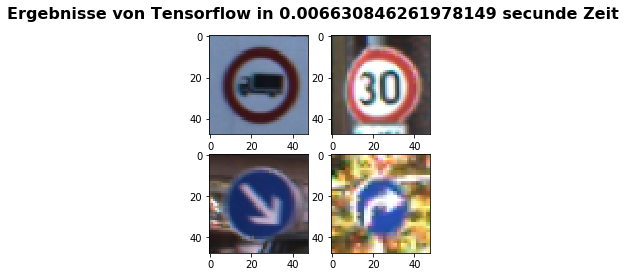

In [8]:
prediction_classes = []
sum_zeit=0
for image in images:
    prediction, zeit = perform_model(fr_graph_tf_model,
                                     input_node,
                                     output_node,
                                     image)
    prediction_classes.append(prediction)
    sum_zeit += zeit

# show image
fig=plt.figure(figsize=(4, 4))
columns = 2
rows = 2
count = 1
for image, label_class,predicted_class in zip(images, labels_classes, prediction_classes):
    fig.add_subplot(rows, columns,count)
    count +=1
    real_label = classe_label[label_class]['SignName']
    real_label = real_label.replace(" ", "\n")
    predicted_label = classe_label[np.argmax(predicted_class[0])]['SignName']
    predicted_label = predicted_label.replace(" ", "\n")
    print("Das Model hat predictd: {}\n und Rictig ist: {}\n".format(predicted_label, real_label))
    plt.imshow(image)
label = 'Ergebnisse von Tensorflow in {} secunde Zeit '.format(sum_zeit/len(images))
fig.suptitle(label, fontsize=16, fontweight="bold")
plt.show()

### tensorRT - Model

der Graph wird gelesen!
der wurde gelesen!
gebrauchte Zeit - 0:  0.006158351898193359
gebrauchte Zeit - 1:  0.006021261215209961
gebrauchte Zeit - 2:  0.005995750427246094
gebrauchte Zeit - 3:  0.0059185028076171875
gebrauchte Zeit - 4:  0.0060272216796875
gebrauchte Zeit - 5:  0.005877494812011719
gebrauchte Zeit - 6:  0.006258249282836914
gebrauchte Zeit - 7:  0.006192445755004883
gebrauchte Zeit - 8:  0.0061800479888916016
gebrauchte Zeit - 9:  0.0060999393463134766
gebrauchte Zeit - 10:  0.012693405151367188
gebrauchte Zeit - 11:  0.013507843017578125
gebrauchte Zeit - 12:  0.007230997085571289
gebrauchte Zeit - 13:  0.008342504501342773
gebrauchte Zeit - 14:  0.006078958511352539
gebrauchte Zeit - 15:  0.006186485290527344
gebrauchte Zeit - 16:  0.00645899772644043
gebrauchte Zeit - 17:  0.006215095520019531
gebrauchte Zeit - 18:  0.0064640045166015625
gebrauchte Zeit - 19:  0.00666046142578125
gebrauchte Zeit - 20:  0.006828784942626953
gebrauchte Zeit - 21:  0.006453514099121094

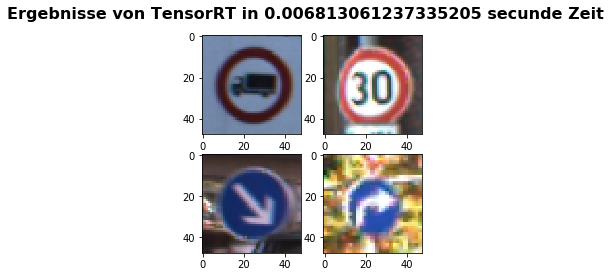

In [9]:
prediction_classes = []
sum_zeit=0
for image in images:
    prediction, zeit = perform_model(fr_graph_trt_model,
                                     input_node,
                                     output_node,
                                     image)
    prediction_classes.append(prediction)
    sum_zeit += zeit

# show image
fig=plt.figure(figsize=(4, 4))
columns = 2
rows = 2
count = 1
for image, label_class,predicted_class in zip(images, labels_classes, prediction_classes):
    fig.add_subplot(rows, columns,count)
    count +=1
    real_label = classe_label[label_class]['SignName']
    real_label = real_label.replace(" ", "\n")
    predicted_label = classe_label[np.argmax(predicted_class[0])]['SignName']
    predicted_label = predicted_label.replace(" ", "\n")
    print("Das Model hat predictd: {}\n und Rictig ist: {}\n".format(predicted_label, real_label))
    plt.imshow(image)
label = 'Ergebnisse von TensorRT in {} secunde Zeit '.format(sum_zeit/len(images))
fig.suptitle(label, fontsize=16, fontweight="bold")
plt.show()